# 语言交互

## 直接导入 Python

In [1]:
import Python

In [4]:
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")

// Also enable Jupyter's display capabilities.
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


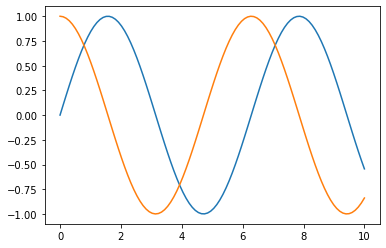

None


In [5]:
let x = np.linspace(0, 10, 100)

plt.plot(x, np.sin(x))
plt.plot(x, np.cos(x))

plt.show()

## 用 Python 玩 AI 游戏

In [6]:
let gym = Python.import("gym")

In [7]:
import TensorFlow

/// Model parameters and hyperparameters.
let hiddenSize = 128
let batchSize = 16
/// Controls the amount of good/long episodes to retain for training.
let percentile = 70

/// An episode is a list of steps, where each step records the observation from
/// env and the action taken. They will serve respectively as the input and
/// target (label) of the neural net training.
struct Episode {
    struct Step {
        let observation: Tensor<Float>
        let action: Int32
    }

    let steps: [Step]
    let reward: Float
}

/// Filtering out bad/short episodes before we feed them as neural net training data.
func filteringBatch(
  episodes: [Episode],
  actionCount: Int
) -> (input: Tensor<Float>, target: Tensor<Float>, episodeCount: Int, meanReward: Float) {
    let rewards = episodes.map { $0.reward }
    let rewardBound = Float(np.percentile(rewards, percentile))!
    print("rewardBound = \(rewardBound)")

    var input = Tensor<Float>(0.0)
    var target = Tensor<Float>(0.0)
    var totalReward: Float = 0.0

    var retainedEpisodeCount = 0
    for episode in episodes {
        if episode.reward < rewardBound {
            continue
        }

        let observationTensor = Tensor<Float>(episode.steps.map { $0.observation })
        let actionTensor = Tensor<Int32>(episode.steps.map { $0.action })
        let oneHotLabels = Tensor<Float>(oneHotAtIndices: actionTensor, depth: actionCount)

        if retainedEpisodeCount == 0 {
            input = observationTensor
            target = oneHotLabels
        } else {
            input = input.concatenated(with: observationTensor)
            target = target.concatenated(with: oneHotLabels)
        }

        totalReward += episode.reward
        retainedEpisodeCount += 1
    }

    return (input, target, retainedEpisodeCount, totalReward / Float(retainedEpisodeCount))
}

struct CartPoleEnvironment {
    let env: PythonObject
    func reset() -> Tensor<Float> {
        return Tensor<Float>(Tensor<Double>(numpy: env.reset())!)
    }
    func step(_ action: Int32) -> (Tensor<Float>, Float, Bool) {
        let (nextObservation, reward, isDone, _) = env.step(Int(action)).tuple4
        return (
            Tensor<Float>(Tensor<Double>(numpy: nextObservation)!),
            Float(reward)!, Bool(isDone)!)
    }
}

extension Tensor where Scalar: TensorFlowFloatingPoint {
    func categorical(samples: Int) -> Tensor<Int32> {
        let logits = self.rank == 1 ? self.reshaped(to: [1, self.shape[0]]) : self
        return Raw.multinomial(
            logits: logits,
            numSamples: Tensor<Int32>(Int32(samples)))
    }
}

### 神经网络

In [9]:
/// A simple two layer dense neural net.
struct Net: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var l1, l2: Dense<Float>

    init(observationSize: Int, hiddenSize: Int, actionCount: Int) {
        l1 = Dense<Float>(inputSize: observationSize, outputSize: hiddenSize, activation: relu)
        l2 = Dense<Float>(inputSize: hiddenSize, outputSize: actionCount)
    }

    @differentiable
    func callAsFunction(_ input: Input) -> Output {
        return input.sequenced(through: l1, l2)
    }
}

### 观察与行动

In [10]:
func nextBatch(env: CartPoleEnvironment, net: Net, batchSize: Int, actionCount: Int) -> [Episode] {
    var observation = env.reset()

    var episodes: [Episode] = []

    // Build up a batch of observations and actions.
    for _ in 0..<batchSize {
        var steps: [Episode.Step] = []
        var episodeReward: Float = 0.0

        // This loop runs one episode.
        while true {
            let action = net(observation.reshaped(to: [1, 4])).categorical(samples: 1).scalarized()
            let (nextObservation, reward, isDone) = env.step(action)
            steps.append(Episode.Step(observation: observation, action: action))

            episodeReward += reward

            if isDone == true {
                episodes.append(Episode(steps: steps, reward: episodeReward))
                observation = env.reset()
                break
            } else {
                observation = nextObservation
            }
        }
    }

    return episodes
}

### 设置游戏环境

In [11]:
let env = CartPoleEnvironment(env: gym.make("CartPole-v0"))
let observationSize = Int(env.env.observation_space.shape[0])!
let actionCount = Int(env.env.action_space.n)!
var meanRewards: [Float] = []

var net = Net(observationSize: Int(observationSize), hiddenSize: hiddenSize, actionCount: actionCount)
let optimizer = Adam(for: net, learningRate: 0.01)
var batchIndex = 0

### 训练算法

In [12]:
while true {
    print("Processing mini batch \(batchIndex)")
    batchIndex += 1

    let episodes = nextBatch(env: env, net: net, batchSize: batchSize, actionCount: actionCount)
    let (input, target, episodeCount, meanReward) = filteringBatch(
      episodes: episodes, actionCount: actionCount)

    let gradients = withLearningPhase(.training) {
        net.gradient { net -> Tensor<Float> in
            let logits = net(input)
            let loss = softmaxCrossEntropy(logits: logits, probabilities: target)
            print("loss is \(loss)")
            return loss
        }
    }
    optimizer.update(&net.allDifferentiableVariables, along: gradients)

    print("It has episode count \(episodeCount) and mean reward \(meanReward)")
    meanRewards.append(meanReward)

    if meanReward > 199 {
        print("Solved")
        break
    }
}

Processing mini batch 0
rewardBound = 20.0
loss is 0.67649126
It has episode count 5 and mean reward 24.6
Processing mini batch 1
rewardBound = 25.0
loss is 0.67553836
It has episode count 5 and mean reward 33.8
Processing mini batch 2
rewardBound = 17.5
loss is 0.67859566
It has episode count 5 and mean reward 26.4
Processing mini batch 3
rewardBound = 22.5
loss is 0.6876042
It has episode count 5 and mean reward 35.0
Processing mini batch 4
rewardBound = 24.0
loss is 0.6698061
It has episode count 6 and mean reward 31.5
Processing mini batch 5
rewardBound = 40.5
loss is 0.6727366
It has episode count 5 and mean reward 48.2
Processing mini batch 6
rewardBound = 34.5
loss is 0.6546298
It has episode count 5 and mean reward 49.2
Processing mini batch 7
rewardBound = 37.5
loss is 0.65005106
It has episode count 5 and mean reward 78.8
Processing mini batch 8
rewardBound = 42.0
loss is 0.64122635
It has episode count 5 and mean reward 79.6
Processing mini batch 9
rewardBound = 61.5
loss is

### 画图

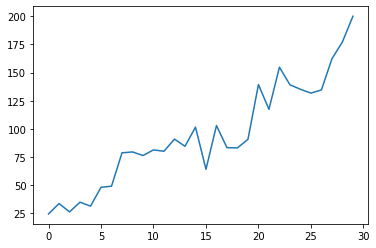

None


In [13]:
plt.plot(meanRewards)
plt.show()

## 直接导入 C

In [18]:
import Glibc

In [19]:
let address = malloc(32)!
let string = address.bindMemory(to: CChar.self, capacity: 32)

// strcpy(string, "Plain old C at Google I/O 2019!")
strcpy(string, "我们可以直接写 C！")
puts(string)

free(address)

我们可以直接使用 C！
